/var/folders/cm/nktmq22d67l9b33d8t__mzbc0000gn/T/ipykernel_66649/1382129276.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[f"{marker}_X"] = butter_lowpass_filter(df[f"{marker}_X"].fillna(method='ffill'), cutoff=3, fs=60)
/var/folders/cm/nktmq22d67l9b33d8t__mzbc0000gn/T/ipykernel_66649/1382129276.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[f"{marker}_Y"] = butter_lowpass_filter(df[f"{marker}_Y"].fillna(method='ffill'), cutoff=3, fs=60)


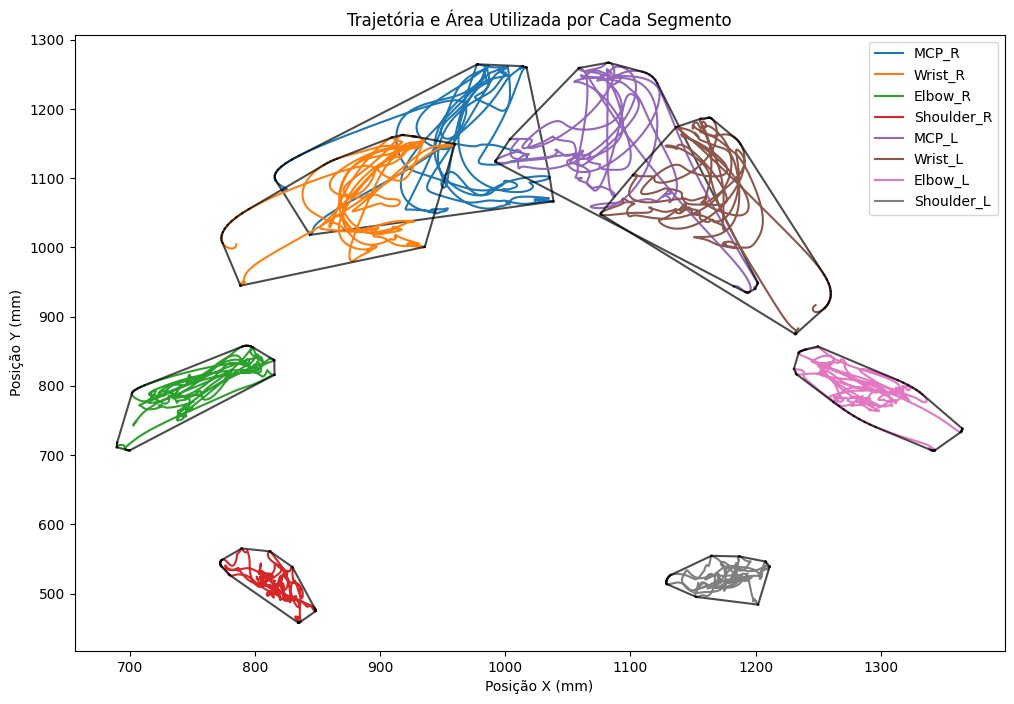

Cálculo concluído! Resultados salvos em: /Users/borba/Desktop/hand_tracking_summary_Valdir.xlsx, /Users/borba/Desktop/hand_tracking_all_Valdir.xlsx, /Users/borba/Desktop/hand_tracking_trajectory_Valdir.png


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.spatial import ConvexHull

Name = 'Valdir'

# Carregar os dados extraídos anteriormente
EXCEL_INPUT_PATH = "/Users/borba/Desktop/hand_tracking_data_Valdir.xlsx"
df = pd.read_excel(EXCEL_INPUT_PATH)

OutputPath = '/Users/borba/Desktop/'

# Definir função para filtro passa-baixa Butterworth
def butter_lowpass_filter(data, cutoff=3, fs=60, order=3):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Lista de marcadores a serem analisados
markers = ["MCP_R", "Wrist_R", "Elbow_R", "Shoulder_R", "MCP_L", "Wrist_L", "Elbow_L", "Shoulder_L"]

# Aplicar filtro aos dados de posição
for marker in markers:
    df[f"{marker}_X"] = butter_lowpass_filter(df[f"{marker}_X"].fillna(method='ffill'), cutoff=3, fs=60)
    df[f"{marker}_Y"] = butter_lowpass_filter(df[f"{marker}_Y"].fillna(method='ffill'), cutoff=3, fs=60)

# Criar colunas para velocidades lineares após filtragem
df['Time_diff'] = df['Time'].diff()
for marker in markers:
    df[f"{marker}_Vx"] = df[f"{marker}_X"].diff() / df['Time_diff']
    df[f"{marker}_Vy"] = df[f"{marker}_Y"].diff() / df['Time_diff']

# Calcular deslocamento total para cada marcador e converter para metros
displacement_results = {}
for marker in markers:
    displacement_x = np.nansum(np.abs(df[f"{marker}_Vx"]) * df['Time_diff']) / 1000
    displacement_y = np.nansum(np.abs(df[f"{marker}_Vy"]) * df['Time_diff']) / 1000
    total_displacement = np.sqrt(displacement_x**2 + displacement_y**2)
    displacement_results[marker] = total_displacement

# Criar gráfico de trajetória e área convexa para cada segmento
plt.figure(figsize=(12, 8))
for marker in markers:
    plt.plot(df[f"{marker}_X"], df[f"{marker}_Y"], label=marker)
    points = np.vstack([df[f"{marker}_X"].dropna(), df[f"{marker}_Y"].dropna()]).T
    if len(points) > 2:
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 'k-', alpha=0.7)
plt.xlabel("Posição X (mm)")
plt.ylabel("Posição Y (mm)")
plt.title("Trajetória e Área Utilizada por Cada Segmento")
plt.legend()
plt.grid(False)

# Salvar gráfico
GRAPH_OUTPUT_PATH = f"{OutputPath}hand_tracking_trajectory_{Name}.png"
plt.savefig(GRAPH_OUTPUT_PATH, dpi=300, bbox_inches='tight')
plt.show()

# Calcular a área usada para cada marcador usando o Convex Hull
area_results = {}
density_results = {}
for marker in markers:
    points = np.vstack([df[f"{marker}_X"].dropna(), df[f"{marker}_Y"].dropna()]).T
    if len(points) > 2:
        hull = ConvexHull(points)
        area_results[marker] = hull.volume / 100  # Convertendo de mm² para cm²
        density_results[marker] = len(points) / area_results[marker]

# Calcular velocidade média para cada marcador
overall_mean_speeds = {}
for marker in markers:
    mean_vx = np.nanmean(np.abs(df[f"{marker}_Vx"]))
    mean_vy = np.nanmean(np.abs(df[f"{marker}_Vy"]))
    overall_mean_speeds[marker] = (mean_vx, mean_vy)

# Calcular assimetria entre os segmentos direito e esquerdo
asymmetry_results = {}
for marker in ["MCP", "Wrist", "Elbow", "Shoulder"]:
    asym_vx = np.abs(np.nanmean(np.abs(df[f"{marker}_R_Vx"])) - np.nanmean(np.abs(df[f"{marker}_L_Vx"])))
    asym_vy = np.abs(np.nanmean(np.abs(df[f"{marker}_R_Vy"])) - np.nanmean(np.abs(df[f"{marker}_L_Vy"])))
    asymmetry_results[marker] = (asym_vx, asym_vy)

# Criar um DataFrame para armazenar os resultados consolidados
results_data = {"Nome": Name}
for marker, displacement in displacement_results.items():
    results_data[f"{marker}_Displacement_m"] = displacement
for marker, area in area_results.items():
    results_data[f"{marker}_Area_cm2"] = area
for marker, density in density_results.items():
    results_data[f"{marker}_Density_points_per_cm2"] = density
for marker, (vx, vy) in overall_mean_speeds.items():
    results_data[f"{marker}_Mean_Vx_mps"] = vx
    results_data[f"{marker}_Mean_Vy_mps"] = vy
for marker, (asym_vx, asym_vy) in asymmetry_results.items():
    results_data[f"{marker}_Asymmetry_Vx_mps"] = asym_vx
    results_data[f"{marker}_Asymmetry_Vy_mps"] = asym_vy

# Criar DataFrame e salvar em um novo arquivo Excel
df_results = pd.DataFrame([results_data])
EXCEL_SUMMARY_PATH = f"{OutputPath}hand_tracking_summary_{Name}.xlsx"
df_results.to_excel(EXCEL_SUMMARY_PATH, index=False)

# Salvar os dados filtrados em um novo arquivo Excel
EXCEL_OUTPUT_PATH = f"{OutputPath}hand_tracking_all_{Name}.xlsx"
df.to_excel(EXCEL_OUTPUT_PATH, index=False)

print(f"Cálculo concluído! Resultados salvos em: {EXCEL_SUMMARY_PATH}, {EXCEL_OUTPUT_PATH}, {GRAPH_OUTPUT_PATH}")
